# __Test notebook__

## MSR Testing

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from utils import msr_to_matrix, make_system,conjugate_gradient,GetKrylovw, gmres_2,givens_rotation,backward_subs
from scipy.linalg import hessenberg

Matrix:
 [[ 4.  0.  2.  0.]
 [ 0.  8.  0.  4.]
 [ 2.  0.  5. -1.]
 [ 0.  4. -1.  8.]]
Matrix 2:
 [[12. -5.  0.  3.]
 [ 0.  4.  0.  0.]
 [ 0.  0.  2.  0.]
 [ 5. -2. -3. 14.]]


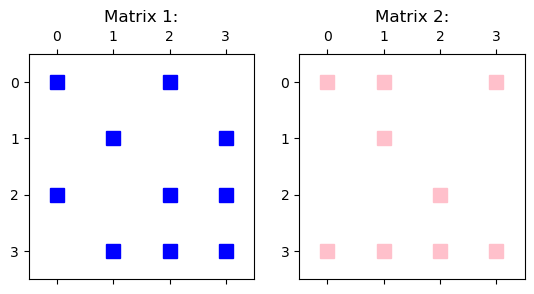

In [12]:
filename = "Data_P1/msr_test_symmetric.txt"; filename2 = "Data_P1/test2.txt" # From MSR_format.pdf
matrix2 = msr_to_matrix(filename2); matrix = msr_to_matrix(filename)

print("Matrix:\n", matrix), print("Matrix 2:\n", matrix2)

plt.subplot(1, 2, 1), plt.spy(matrix, markersize=10, color='b'), plt.title("Matrix 1:")
plt.subplot(1, 2, 2), plt.spy(matrix2, markersize=10, color='pink'), plt.title("Matrix 2:")
plt.show()  # Display the plots

[1. 1. 1. 1.]


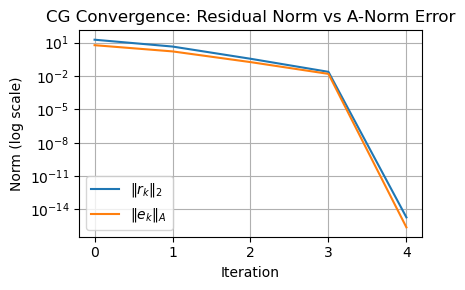

In [ ]:
## CG vs Actual results:
tol = 1e-8

A,b,x,x0 = make_system(matrix)
x, r_norms, e_A_norms = conjugate_gradient(matrix, b, x0, x,tol,100 )

plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1), plt.semilogy(r_norms, label=r'$\|r_k\|_2$'), plt.semilogy(e_A_norms, label=r'$\|e_k\|_A$'), plt.xlabel('Iteration'), plt.ylabel('Norm (log scale)')
plt.title('CG Convergence: Residual Norm vs A-Norm Error'),plt.legend(), plt.grid(True),plt.tight_layout()
print(x)

## GMRES Testing

1. Restarded GMRES with m =600
2. GMRES with 
* Jacobi 
* GS 
* ILU (0)

#### Krylov testing:

In [ ]:
#Krylovw test
k = 4
A,b,x,x0 = make_system(matrix)
r0 = b - A @ x0
V_0 = r0 / np.linalg.norm(r0)
V_j, H_j = GetKrylovw(A, V_0, k)
#H_j = H[:j] # last column oj H
V_k = V_j[:, :k] 
V_kplus1 = V_j[:, :k+1]
H_k = H_j[:k+1, :k]
#print(H_j)
#print(H_k)
residual = A @ V_k - V_kplus1 @ H_k
error = np.linalg.norm(residual)
print("Error: ||A V_k - V_{k+1} H_k|| =", error)

Error: ||A V_k - V_{k+1} H_k|| = 1.368774871883577e-15


### GMRES full implementation

In [ ]:
import scipy.sparse as sp
import scipy.sparse.linalg as spla
from scipy.sparse.linalg import LinearOperator


In [ ]:
def apply_preconditioner(M_inv, r):
    return M_inv(r)

def make_preconditioned_operator(A, M_inv):
    """
    Create a LinearOperator that represents M⁻¹A
    """
    A = sp.csr_matrix(A)  # Ensure sparse
    n = A.shape[0]
    def mv(v):
        return M_inv(A @ v)
    return LinearOperator(shape=(n, n), matvec=mv, dtype=A.dtype)

def givens_rotation(hessenber_m_func , norm_v_o):
    H_m = hessenber_m_func.copy()
    m = len(H_m[:,0])-1
    g = np.zeros(m+1)
    g[0] = norm_v_o
    for r in range(m):
        h = (H_m[r,r]**2 +H_m[r+1,r]**2)**(0.5)
        c = H_m[r,r]/h
        s = H_m[r+1,r]/h
        rotation_m = np.array([[c, s], [-s, c]])
        g[r:r+2] = np.matmul(rotation_m,g[r:r+2])
        H_m[r,r] = h
        H_m[r+1,r] = 0
        for j in range (r+1,m):
            H_m[r:r+2,j] = np.matmul(rotation_m,H_m[r:r+2,j])
    return(H_m , g)

In [ ]:
def GMRES(A, b, x0=None, restart=10, tol=1e-8, maxiter=None, preconditioner=None):
    """
    Restarted GMRES implementation using Get Krylovw.
    Parameters:
        A : np.ndarray
        b : np.ndarray
        x0 : initial guess
        restart : int, restart parameter (number of Krylov vectors)
        tol : convergence tolerance
        maxiter : maximum number of outer iterations (defaults to n)
        preconditioner : str or callable, one of {None, 'jacobi', 'gauss-seidel', 'ilu'}

    Returns:
        x : approximate solution
        residuals : list of residual norms
    """
    n = A.shape[0]
    if x0 is None:
        x0 = np.zeros_like(b)
    if maxiter is None:
        maxiter = n

    x = x0.copy()
    r0 = b - A @ x
    beta = np.linalg.norm(r0)
    residuals = [beta]
    residuals_be = [beta]
    it = 0

    # --- Setup preconditioner
    if preconditioner is None:
        M_inv = lambda r:r
    elif preconditioner == 'jacobi':
        D_inv = 1.0 / A.diagonal()
        M_inv = lambda r: D_inv * r
    elif preconditioner == 'gauss-seidel':
        L = sp.tril(A).tocsc()
        M_inv = lambda r: spla.spsolve(L, r)
    elif preconditioner == 'ilu':
        #TODO
        M_inv = lambda r:r
    else:
        raise ValueError(f"Unknown preconditioner: {preconditioner}")


    while beta>10e-8 and it < maxiter:
        r0 = b - A @ x
        z0 = apply_preconditioner(M_inv, r0)
        beta = np.linalg.norm(r0)
        residuals_be.append(beta)
        
        if beta < tol:
            break

        A_po= make_preconditioned_operator(A, M_inv) #lambda v: apply_preconditioner(M_inv, A @ v) #
        V, H = GetKrylovw(A_po, z0, restart) # Arnoldi process to get V and H
        
        m = H.shape[1]
        # Givens rotation coefficients
        cs = np.zeros(m)
        sn = np.zeros(m)
        e1 = np.zeros(m + 1)
        e1[0] = beta
        # Apply Givens rotations to H
        for j in range(m):
            # Apply previous rotations
            for i in range(j):
                temp = cs[i] * H[i, j] + sn[i] * H[i + 1, j]
                H[i + 1, j] = -sn[i] * H[i, j] + cs[i] * H[i + 1, j]
                H[i, j] = temp
            # Compute new Givens rotation
            r = np.hypot(H[j, j], H[j + 1, j])
            if r == 0:
                cs[j] = 1.0
                sn[j] = 0.0
            else:
                cs[j] = H[j, j] / r
                sn[j] = H[j + 1, j] / r
            # Apply it
            H[j, j] = cs[j] * H[j, j] + sn[j] * H[j + 1, j]
            H[j + 1, j] = 0.0
            e1[j + 1] = -sn[j] * e1[j]
            e1[j] = cs[j] * e1[j]

            # Check for convergence
            resid = abs(e1[j + 1])
            residuals.append(resid)
        if resid < tol:
                m = j + 1
                break

        # Least squares solve for y
        y = np.linalg.solve(H[:m, :m], e1[:m])

        # Update solution
        x += V[:, :m] @ y
        beta = resid
        residuals_be.append(beta)
        it += m


    return x, residuals, it, j, residuals_be


Text(0.5, 1.0, 'Dense representation of msr matrix:')

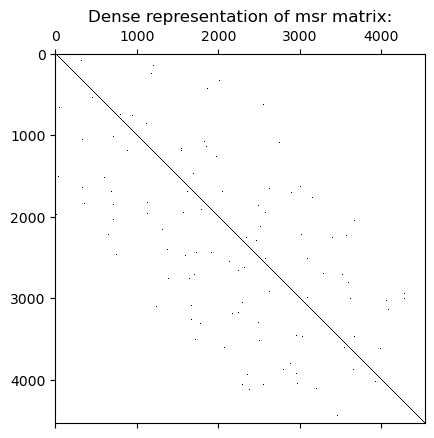

In [ ]:
matrix = msr_to_matrix("Data_P1/gmres_matrix_msr_1.txt")
A,b,x,x0 = make_system(matrix)
plt.spy(A)
plt.title("Dense representation of msr matrix:")

## GMRES

In [1]:
import numpy as np
from utils import gmres_2
import matplotlib.pyplot as plt
filename = "Data_P1/gmres_matrix_msr_1.txt"

In [11]:
x, residuals, x_axis = gmres_2(filename, relative_residual=1e-8,k_dim=10, max_iterations=600, precon_method="identity")

In [4]:
x_j, residuals_j, x_axis_j = gmres_2(filename, relative_residual=1e-8,k_dim=1, max_iterations=600, precon_method="jacobi")

In [3]:
x_g, residuals_g, x_axis_g = gmres_2(filename, relative_residual=1e-8,k_dim=1, max_iterations=600, precon_method="gauss")

In [2]:
x_i, residuals_i, x_axis_i = gmres_2(filename, relative_residual=1e-8,k_dim=1, max_iterations=600, precon_method="ilu")

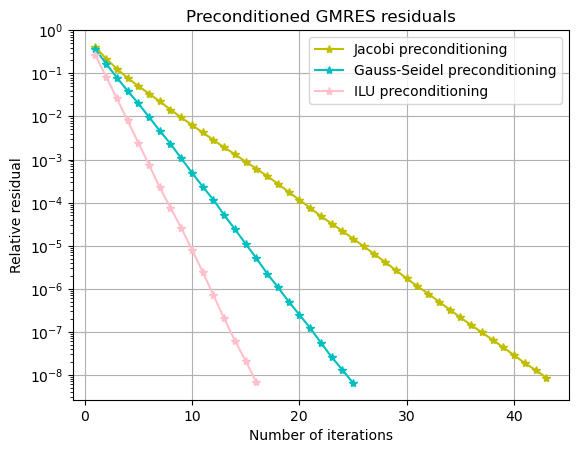

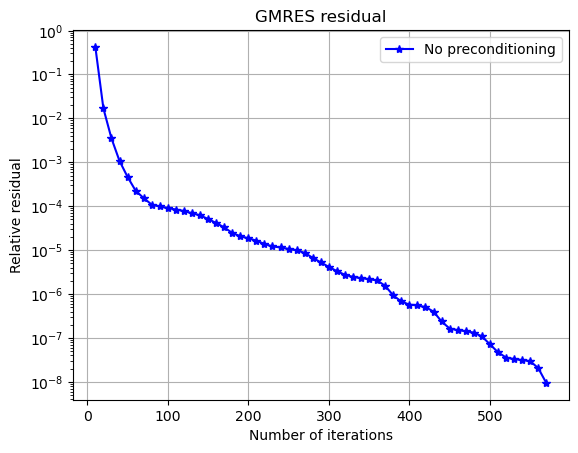

In [15]:
plt.title("Preconditioned GMRES residuals")
plt.xlabel("Number of iterations")
plt.ylabel("Relative residual")

plt.semilogy(x_axis_j, residuals_j,  '*-', color='y', label="Jacobi preconditioning")
plt.semilogy(x_axis_g, residuals_g, '*-', color='c', label="Gauss-Seidel preconditioning")
plt.semilogy(x_axis_i, residuals_i, '*-', color='pink', label="ILU preconditioning")



plt.legend()
plt.grid()
plt.show()

plt.title("GMRES residual")
plt.xlabel("Number of iterations")
plt.ylabel("Relative residual")
plt.semilogy(x_axis, residuals, '*-', color='b', label="No preconditioning")
plt.legend()
plt.grid()
plt.show()

#print(f"Error eucledean norm: {np.linalg.norm(x[:len(residuals)] - residuals)}")